캐글 신용카드 거래내용이 포함된 데이터 셋을 아래 사이트에서 다운받아 다음 사항을 수행하세요.

https://www.kaggle.com/mlg-ulb/creditcardfraud

데이터 세트에는 유럽 카드 소지자가 2013년 9월에 신용 카드로 거래한 내용이 포함되어 있습니다.
이 데이터 세트는 284,807건의 거래 중 492건의 사기가 발생한 이틀 동안 발생한 거래를 보여줍니다. 데이터 세트는 매우 불균형하며 긍정적 클래스(사기)는 모든 거래의 0.172%를 차지합니다.
여기에는 PCA 변환의 결과인 숫자 입력 변수만 포함됩니다. 안타깝게도 기밀 문제로 인해 데이터에 대한 원래 기능과 추가 배경 정보를 제공할 수 없습니다. 기능 V1, V2, … V28은 PCA로 얻은 주요 구성 요소이며 PCA로 변환되지 않은 유일한 기능은 '시간'과 '양'입니다. 기능 '시간'에는 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 초가 포함됩니다. 'Amount' 기능은 거래 금액이며, 이 기능은 예제 종속 비용에 민감한 학습에 사용할 수 있습니다. 기능 'Class'는 응답 변수이며 사기의 경우 값 1, 그렇지 않은 경우 0을 취합니다.

- 데이터 전처리 후 로지스틱 리그레션을 적용한 모델 학습 및 평가(정확도, 정밀도, 재현율, F1 score, AUC)
- Amount 피처를 정규분포 및 로그 변환 후 모델 학습 및 평가
- 상관성이 높은 피처 한개를 선택하여 이상치 데이터 제거 후 모델 학습 및 평가
- SMOTE 오버 샘플링 적용 후 모델 학습 및 평가
- SMOTE 적용 시 인사이트 요약


In [7]:
!pip install imbalanced-learn

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('./dataset/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
from sklearn.model_selection import train_test_split

df_copy=card_df.copy()
df_copy.drop(['Time'],axis=1,inplace=True)

X = df_copy.iloc[:,:-1]
y = df_copy.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

In [11]:
# 로지스틱 회귀 평가
from sklearn.metrics import accuracy_score, precision_score,recall_score, confusion_matrix,f1_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
def get_clf_evals(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    
    print(f'오차 행렬:\n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}, f1 score: {round(f1,4)}, auc: {round(roc_auc,4)}')



In [12]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lr_pred,lr_pred_proba)

AttributeError: 'str' object has no attribute 'decode'

In [13]:
# LightGBM으로 학습 후 평가

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)

lgbm_clf.fit(X_train,y_train)
lgbm_pred = lgbm_clf.predict(X_test)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lgbm_pred,lgbm_pred_proba)

오차 행렬:
 [[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, f1 score: 0.8453, auc: 0.979


<AxesSubplot:xlabel='Amount', ylabel='Density'>

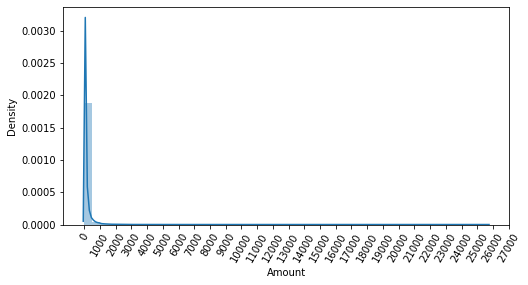

In [14]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])

In [15]:
from sklearn.preprocessing import StandardScaler
#정규 변환
df_copy=card_df.copy()
scaler = StandardScaler()
amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
df_copy.insert(0,'Amount_Scaled',amount_n)

df_copy.drop(['Time','Amount'],axis=1,inplace=True)

X = df_copy.iloc[:,:-1]
y = df_copy.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

In [16]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lr_pred,lr_pred_proba)

오차 행렬:
 [[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, f1 score: 0.7143, auc: 0.9702


In [17]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
lgbm_clf.fit(X_train,y_train)
lgbm_pred = lgbm_clf.predict(X_test)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lgbm_pred,lgbm_pred_proba)

오차 행렬:
 [[85256    39]
 [  121    27]]
정확도: 0.9981, 정밀도: 0.4091, 재현율: 0.1824, f1 score: 0.2523, auc: 0.5943


In [18]:
#로그 변환
df_copy=card_df.copy()

amount_n = np.log1p(df_copy['Amount'])
df_copy.insert(0,'Amount_Scaled',amount_n)

df_copy.drop(['Time','Amount'],axis=1,inplace=True)

X = df_copy.iloc[:,:-1]
y = df_copy.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

In [19]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lr_pred,lr_pred_proba)

오차 행렬:
 [[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, f1 score: 0.7149, auc: 0.9727


In [20]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
lgbm_clf.fit(X_train,y_train)
lgbm_pred = lgbm_clf.predict(X_test)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lgbm_pred,lgbm_pred_proba)

오차 행렬:
 [[85219    76]
 [   58    90]]
정확도: 0.9984, 정밀도: 0.5422, 재현율: 0.6081, f1 score: 0.5732, auc: 0.8069


<AxesSubplot:>

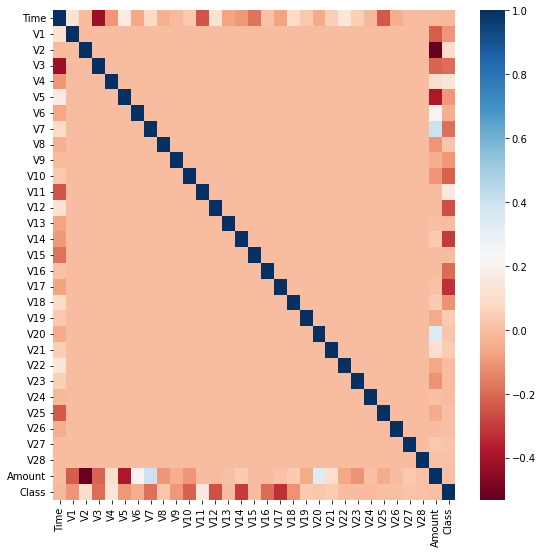

In [21]:
# 이상치 데이터 제거

import seaborn as sns
plt.figure(figsize=(9,9))

corr  = card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [22]:
def get_outlier(df=None,column=None,weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values,75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = weight*iqr
    low_val = quantile_25-iqr_weight
    high_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud<low_val)|(fraud>high_val)].index
    return outlier_index

In [23]:
outliers = get_outlier(df=card_df,column='V14',weight=1.5)
outliers

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [24]:
df_copy=card_df.copy()

amount_n = np.log1p(df_copy['Amount'])
df_copy.insert(0,'Amount_Scaled',amount_n)

df_copy.drop(['Time','Amount'],axis=1,inplace=True)
outliers  = get_outlier(df=df_copy,column='V14',weight=1.5)

df_copy.drop(outliers ,axis=0,inplace=True)


X = df_copy.iloc[:,:-1]
y = df_copy.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

In [25]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lr_pred,lr_pred_proba)

오차 행렬:
 [[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.875, 재현율: 0.6712, f1 score: 0.7597, auc: 0.9743


In [26]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
lgbm_clf.fit(X_train,y_train)
lgbm_pred = lgbm_clf.predict(X_test)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lgbm_pred,lgbm_pred_proba)

오차 행렬:
 [[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534, f1 score: 0.7774, auc: 0.9219


In [27]:
# SMOTE 오버 샘플링 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)
print(X_train_over.shape, y_train_over.shape)

(398040, 29) (398040,)


In [28]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_over,y_train_over)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lr_pred,lr_pred_proba)

오차 행렬:
 [[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, f1 score: 0.1023, auc: 0.9737


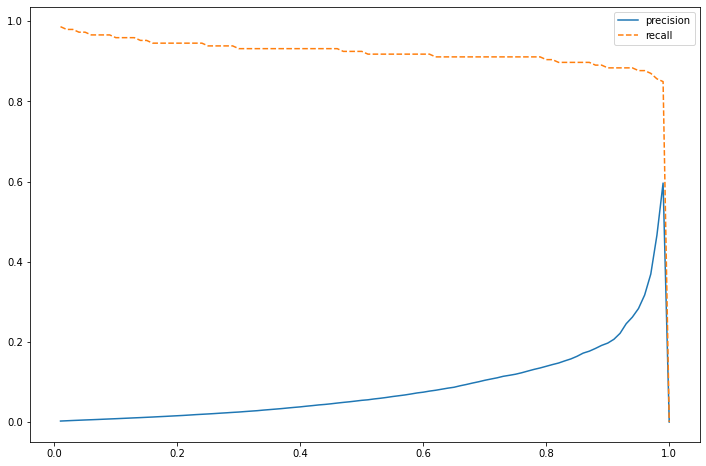

In [29]:
from sklearn.preprocessing import Binarizer
xs = np.arange(1,101)*0.01
prec_list = []
reca_list = []
pred_proba_1 = lr_pred_proba.reshape(-1,1)
for i in range(100):
    cust_threshold = xs[i]
    binarizer = Binarizer(threshold = cust_threshold).fit(pred_proba_1)
    custom_predict=binarizer.transform(pred_proba_1)
    precision = precision_score(y_test,custom_predict)
    prec_list.append(precision)
    recall = recall_score(y_test,custom_predict)
    reca_list.append(recall)
    
plt.figure(figsize = (12,8))
plt.plot(xs, prec_list,label = 'precision')
plt.plot(xs,reca_list,ls = '--',label = 'recall')
plt.legend()
plt.show()

In [30]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
lgbm_clf.fit(X_train_over,y_train_over)
lgbm_pred = lgbm_clf.predict(X_test)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)[:,1]
get_clf_evals(y_test,lgbm_pred,lgbm_pred_proba)

오차 행렬:
 [[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, f1 score: 0.8794, auc: 0.9814


SMOTE 적용 시 재현율이 높아지나 정밀도는 낮아지는 것이 일반적이다. 좋은 SMOTE 패키지일 수록 재현율은 개선하고 정밀도 감소율은 낮출 수 있도록 효과가 개선된다.